In [90]:

import numpy as np 
import pandas as pd 


### Introduction <a class="anchor" id="chapter1"></a>

This notebook aims at analysing the customer information in a company's database. To find out the group that is most likely to buy the products,customer segmentation can identify the target customers. After applying principal component analysis and k-means clustering on the dataset, we divide the customers into three groups. In short, we categorise the customers into groups of low, mid and high income and expenditure.

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [92]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
# df.describe()

In [93]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [94]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

### Data Wrangling <a class="anchor" id="chapter2"></a>

In [95]:
# First deal with marital status
df.Marital_Status.unique() 
# we simply put the customer into 2 categories: in_relationship and not_in_relationship
# combineing the relationship to the teen and kid at home:
# adding 2 to the family size if the customer is in relationship, on the contrary, we add one 

cust_relationship = {
    'Single' : 1,
    'Together' : 2,
    'Married' : 2,
    'Divorced' : 1,
    'Widow' : 1,
    'Alone' : 1,
    'Absurd' : 1,
    'YOLO' : 1
}

df['re_Marital_Status'] = df['Marital_Status'].map(cust_relationship)

for i in range(len(df)):
    df['Family_Size'] = df['re_Marital_Status'] + df['Teenhome'] + df['Kidhome']


In [96]:
# sum all the accepted campigans 
df['Cmp_accepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + \
df['AcceptedCmp5'] + df['Response']

In [97]:
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,re_Marital_Status,Family_Size,Cmp_accepted
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,3,11,1,1,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,3,11,0,1,3,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,3,11,0,2,2,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,3,11,0,2,3,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,3,11,0,2,3,0


In [98]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")
# the lastest day of the date of 06/12/2014, so we assumer the dataset is extracted on 07/12/2014
# thus the days of registion is calculated as below:

df['extracted_date'] = '07/12/2014'
df['extracted_date'] = pd.to_datetime(df['extracted_date'])
df['Reg_Days'] = df['extracted_date'] - df['Dt_Customer']
df['Reg_Days'] = df['Reg_Days'].dt.days
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,re_Marital_Status,Family_Size,Cmp_accepted,extracted_date,Reg_Days
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,3,11,1,1,1,1,2014-07-12,676
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,3,11,0,1,3,0,2014-07-12,126
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,3,11,0,2,2,0,2014-07-12,325
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,3,11,0,2,3,0,2014-07-12,152
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,3,11,0,2,3,0,2014-07-12,174


In [99]:
# sum the total products purchased
df['Tot_Products'] = df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] + \
    df['MntWines'] + df['MntSweetProducts'] + df['MntGoldProds']

In [100]:
# replace the na value in the 'Income' column with the mean of income
df.loc[(df['Income'].isnull() == True), 'Income'] = df['Income'].mean()

In [101]:
df.drop_duplicates(inplace=True)

In [102]:
df['Age'] = 2014 - df['Year_Birth']

In [103]:
df2 = df.loc[: ,['Age','Income', 'Recency', 'Family_Size','Cmp_accepted','NumDealsPurchases','Reg_Days','Tot_Products','NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']]

In [104]:
df2.describe()

,Age,Income,Recency,Family_Size,Cmp_accepted,NumDealsPurchases,Reg_Days,Tot_Products,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,45.194196,52247.251354,49.109375,2.595089,0.446875,2.325000,366.582143,605.798214,4.084821,2.662054,5.790179,5.316518
std,11.984069,25037.797168,28.962453,0.906959,0.890543,1.932238,202.122512,602.249288,2.778714,2.923101,3.250958,2.426645
min,18.000000,1730.000000,0.000000,1.000000,0.000000,0.000000,13.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,35538.750000,24.000000,2.000000,0.000000,1.000000,193.750000,68.750000,2.000000,0.000000,3.000000,3.000000
50%,44.000000,51741.500000,49.000000,3.000000,0.000000,2.000000,368.500000,396.000000,4.000000,2.000000,5.000000,6.000000
75%,55.000000,68289.750000,74.000000,3.000000,1.000000,3.000000,542.000000,1045.500000,6.000000,4.000000,8.000000,7.000000
max,121.000000,666666.000000,99.000000,5.000000,5.000000,15.000000,712.000000,2525.000000,27.000000,28.000000,13.000000,20.000000


### PCA <a class="anchor" id="chapter3"></a>

In [105]:
# standardize the data before PCA to avoid putting more weight on the columns who have large value
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2)
df2_scaled

array([[ 0.98534473,  0.23532677,  0.30703926, ...,  2.51089024,
        -0.55078479,  0.69390374],
       [ 1.23573295, -0.23582624, -0.38366418, ..., -0.56871962,
        -1.1661254 , -0.13046347],
       [ 0.3176428 ,  0.77363327, -0.79808624, ..., -0.22654075,
         1.29523705, -0.54264708],
       ...,
       [-1.01776106,  0.18910632,  1.44669994, ...,  0.11563813,
         2.21824797,  0.28172013],
       [ 1.06880747,  0.67903514, -1.41971934, ...,  0.79999587,
         1.29523705, -0.95483068],
       [ 1.23573295,  0.02483795, -0.31459383, ..., -0.56871962,
        -0.55078479,  0.69390374]])

In [106]:
pca = PCA()
pca.fit(df2_scaled)

PCA()

In [107]:
pca.explained_variance_ratio_
pca.explained_variance_ratio_.cumsum()

array([0.33373067, 0.48012681, 0.58112047, 0.66653057, 0.73703807,
       0.80292986, 0.85622596, 0.89966923, 0.934556  , 0.96444513,
       0.98732419, 1.        ])

Text(0, 0.5, 'cumculative explained variance')

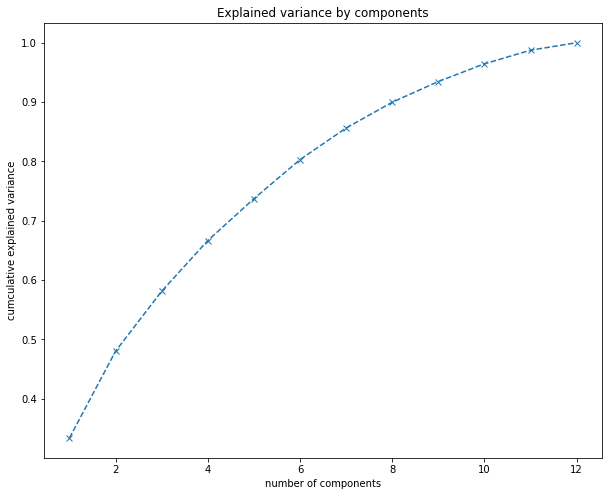

In [108]:
plt.figure(figsize=(10,8))
plt.plot(range(1,13), pca.explained_variance_ratio_.cumsum(), marker='x', linestyle="--")
plt.title('Explained variance by components')
plt.xlabel('number of components')
plt.ylabel('cumculative explained variance')

In [109]:
# we take the number of components that account for 90% of the explained variance
pca6 = PCA(n_components=6)

In [110]:
pca6.fit(df2_scaled)

PCA(n_components=6)

In [111]:
pca6.transform(df2_scaled)
score_pca6 = pca6.transform(df2_scaled)
score_pca6

array([[ 2.58991434,  1.41337599, -1.20949804,  0.69590222,  1.62814554,
        -0.5561767 ],
       [-1.63638898, -1.11454928,  1.38839997, -0.84556169,  0.76535461,
         0.08978685],
       [ 1.51219422, -0.10020302,  0.39212027, -0.64238807, -0.50885278,
        -1.2103388 ],
       ...,
       [ 1.65086857, -1.25385585, -0.74973675,  1.56302891, -0.68378815,
         0.35167554],
       [ 1.6100845 , -0.11931793,  1.56220701, -1.65019396, -0.49497386,
        -0.64541162],
       [-1.21056527,  1.35764878,  0.26770526, -0.62349081,  1.49961663,
         0.22459389]])

we obtain 90% variance 

### K-Means Clustering <a class="anchor" id="chapter4"></a>

In [112]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(score_pca6)
    wcss.append(kmeans_pca.inertia_)

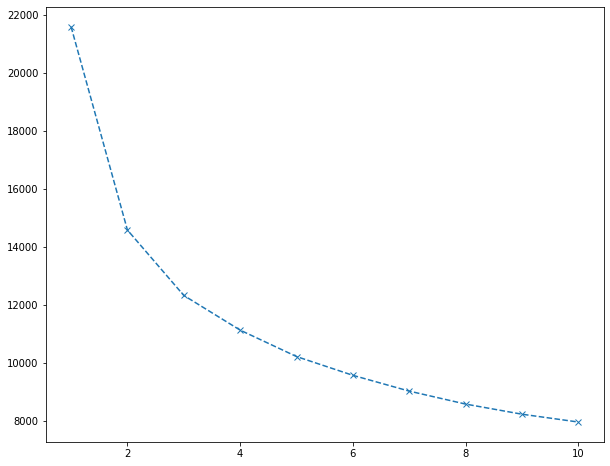

In [113]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='x', linestyle='--')

In [114]:
# from the graph above, we choose 3 as the number of clusters since the curve becomes smoother after 3
kmeans_pca = KMeans(n_clusters= 3, init='k-means++', random_state= 20)

In [115]:
kmeans_pca.fit_transform(score_pca6)

array([[5.19641748, 3.3293073 , 2.97242969],
       [1.9560175 , 3.7078647 , 4.643998  ],
       [3.67529178, 2.2789146 , 2.0509516 ],
       ...,
       [3.97469884, 3.62660299, 2.09170335],
       [4.23054404, 2.86977222, 2.8207511 ],
       [2.50295764, 2.46857778, 4.61611222]])

In [116]:
pd.DataFrame(score_pca6)

,0,1,2,3,4,5
0,2.589914,1.413376,-1.209498,0.695902,1.628146,-0.556177
1,-1.636389,-1.114549,1.388400,-0.845562,0.765355,0.089787
2,1.512194,-0.100203,0.392120,-0.642388,-0.508853,-1.210339
3,-2.089308,-0.951422,-0.359891,-0.714418,-1.170196,0.201661
4,-0.286042,0.505508,0.838124,1.246985,-1.509247,1.225452
...,...,...,...,...,...,...
2235,0.878603,0.775202,0.309175,-0.098092,-0.156796,-0.167705
2236,-0.537685,2.508622,2.819581,-1.368031,0.349098,2.325451
2237,1.650869,-1.253856,-0.749737,1.563029,-0.683788,0.351676
2238,1.610084,-0.119318,1.562207,-1.650194,-0.494974,-0.645412


In [117]:
df2_pca_kmeans = pd.concat([df2.reset_index(drop=True), \
    pd.DataFrame(score_pca6)], axis=1)
df2_pca_kmeans.columns.values[-6:] = ['pc1', 'pc2','pc3', 'pc4','pc5','pc6']

df2_pca_kmeans['cluster'] = kmeans_pca.labels_

In [118]:
df2_pca_kmeans.head()

,Age,Income,Recency,Family_Size,Cmp_accepted,NumDealsPurchases,Reg_Days,Tot_Products,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,pc1,pc2,pc3,pc4,pc5,pc6,cluster
0,57,58138.0,58,1,1,3,676,1617,8,10,4,7,2.589914,1.413376,-1.209498,0.695902,1.628146,-0.556177,2
1,60,46344.0,38,3,0,2,126,27,1,1,2,5,-1.636389,-1.114549,1.388400,-0.845562,0.765355,0.089787,0
2,49,71613.0,26,2,0,1,325,776,8,2,10,4,1.512194,-0.100203,0.392120,-0.642388,-0.508853,-1.210339,2
3,30,26646.0,26,3,0,2,152,53,2,0,4,6,-2.089308,-0.951422,-0.359891,-0.714418,-1.170196,0.201661,0
4,33,58293.0,94,3,0,5,174,422,5,3,6,5,-0.286042,0.505508,0.838124,1.246985,-1.509247,1.225452,1


In [119]:
df2_pca_kmeans['cluster'] = df2_pca_kmeans['cluster'].map({0:'First', 1:'Second', 2:'Third'})
df2_pca_kmeans.head()

,Age,Income,Recency,Family_Size,Cmp_accepted,NumDealsPurchases,Reg_Days,Tot_Products,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,pc1,pc2,pc3,pc4,pc5,pc6,cluster
0,57,58138.0,58,1,1,3,676,1617,8,10,4,7,2.589914,1.413376,-1.209498,0.695902,1.628146,-0.556177,Third
1,60,46344.0,38,3,0,2,126,27,1,1,2,5,-1.636389,-1.114549,1.388400,-0.845562,0.765355,0.089787,First
2,49,71613.0,26,2,0,1,325,776,8,2,10,4,1.512194,-0.100203,0.392120,-0.642388,-0.508853,-1.210339,Third
3,30,26646.0,26,3,0,2,152,53,2,0,4,6,-2.089308,-0.951422,-0.359891,-0.714418,-1.170196,0.201661,First
4,33,58293.0,94,3,0,5,174,422,5,3,6,5,-0.286042,0.505508,0.838124,1.246985,-1.509247,1.225452,Second


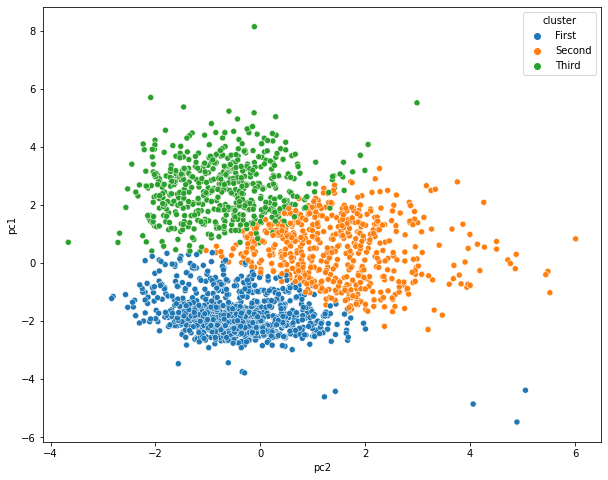

In [120]:
plt.figure(figsize = (10,8))
sns.scatterplot(x='pc2', y='pc1', data=df2_pca_kmeans, hue='cluster', hue_order=['First', 'Second','Third'])

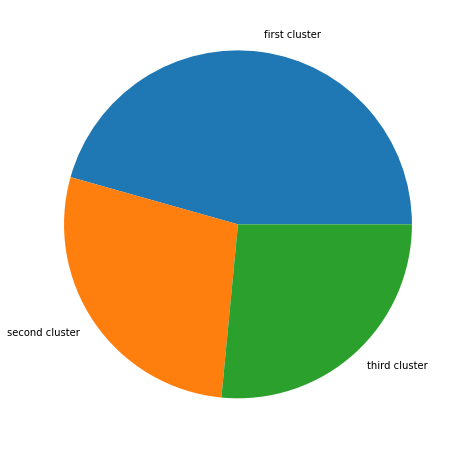

In [121]:
plt.figure(figsize = (8,8))
pie = df2_pca_kmeans.groupby(['cluster']).size().to_frame().reset_index()
pie.rename(columns={0: 'count'}, inplace=True)

pie_labels = ['first cluster', 'second cluster', 'third cluster']
plt.pie(pie['count'], labels=pie_labels)
plt.show()

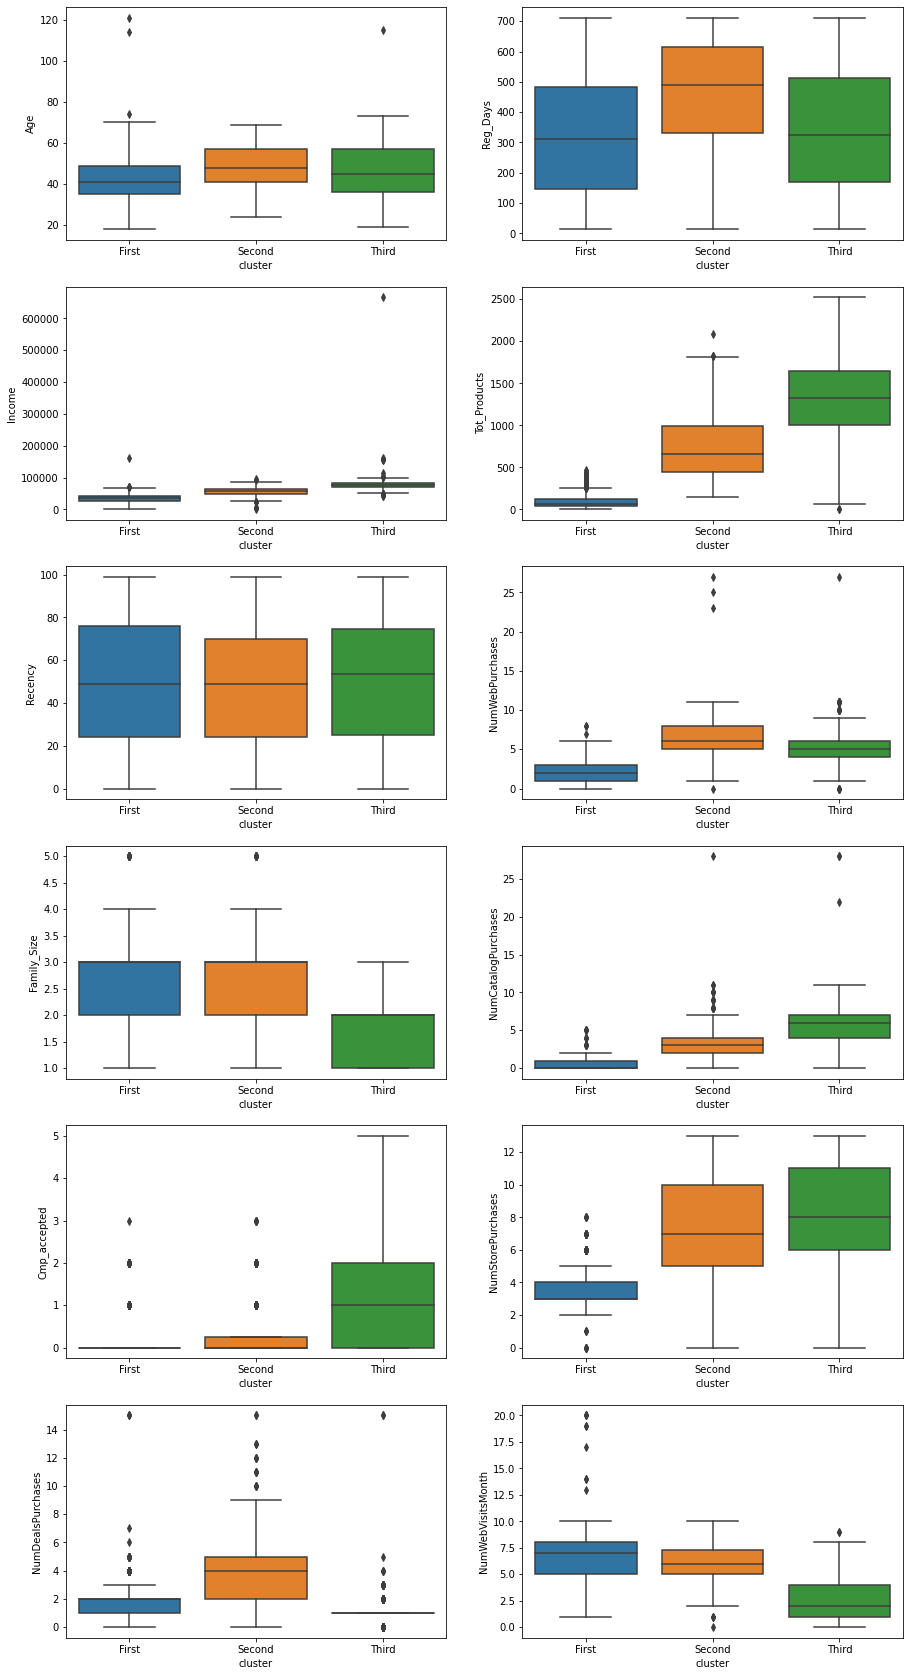

In [122]:
fig, axs = plt.subplots(ncols=2, nrows=6, figsize=(15,30))
for cols, x in zip(df2_pca_kmeans.columns[:6], range(6)):
    for y in range(1):
        sns.boxplot(y=cols, x='cluster', data=df2_pca_kmeans, order=['First', 'Second','Third'], ax=axs[x,y], showfliers = True )

for cols, x in zip(df2_pca_kmeans.columns[6:], range(6)):
    for y in range(1,2):
        sns.boxplot(y=cols, x='cluster', data=df2_pca_kmeans, order=['First', 'Second','Third'], ax=axs[x,y], showfliers = True )


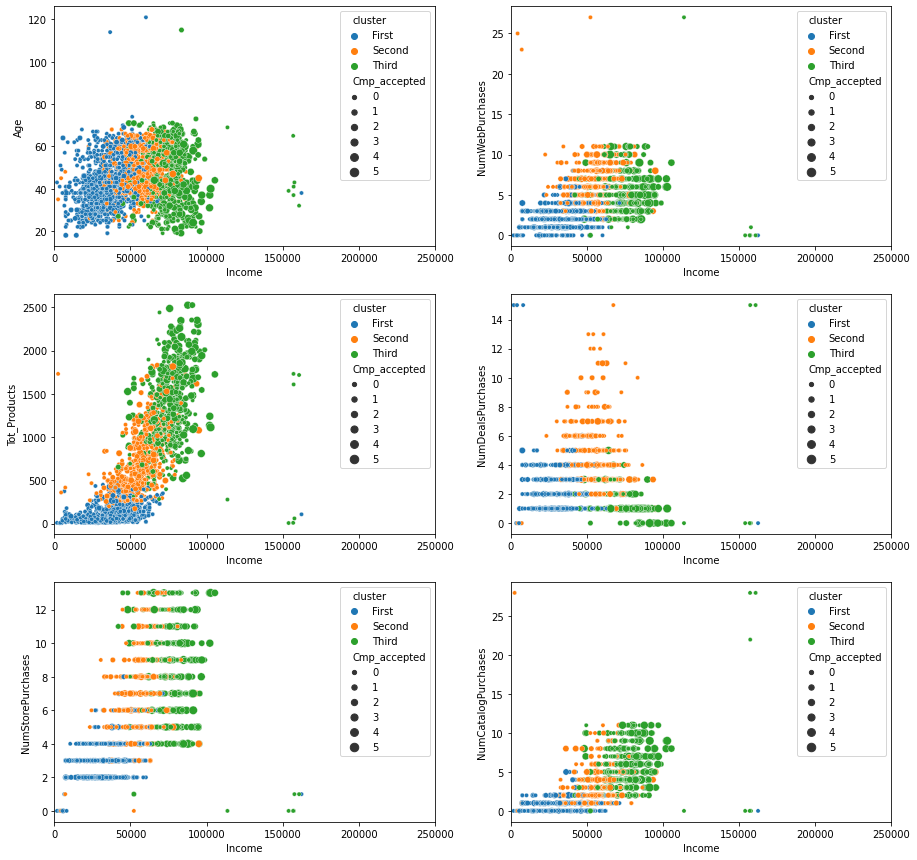

In [123]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,15))

for cols, x in zip(['Age', 'Tot_Products','NumStorePurchases',], range(3)):
    for y in range(1):
        sns.scatterplot(x='Income',y=cols, data=df2_pca_kmeans, hue='cluster', size='Cmp_accepted' ,palette="tab10", ax=axs[x,y], hue_order=['First', 'Second','Third']).set(xlim=(0,250000))

for cols, x in zip(['NumWebPurchases','NumDealsPurchases','NumCatalogPurchases'], range(3)):
    for y in range(1,2):
        sns.scatterplot(x='Income',y=cols, data=df2_pca_kmeans, hue='cluster', size='Cmp_accepted' ,palette="tab10", ax=axs[x,y], hue_order=['First', 'Second','Third']).set(xlim=(0,250000))

### Results and Conclusion <a class="anchor" id="chapter5"></a>

Group 1: Average Customers

People in this group have an average income, buy the average amount of products. Most of them engage in only one campaign,but they make more purchases when there is a discount. They tendto shop online more often than the other two groups.

Group 2: Low-Income and Low-Engagemnet Customers

This group of customers has the lowest purchasing ability andspend very little on this company. Nearly all of them don’tparticipate in a campaign. However, they like to visit theonline shop homepage.

Group 3: High-Income and High-Spending Customers

Contrary to the second group, the third group has the highest incomeand purchasing record. Customers in this cluster usually have smallfamily sizes, accept more campaigns and love to make purchases instores or catalogs. They don’t visit shop website much but they stillmake moderate numbers of the web purchase. Also, the discount isnot attractive to them.

It is important to note that the size of the second group is the largest as it accounts for nearly half of the total customers. The size ofthe other two groups is similar;Here, we performed PCA on given data set for reducing dimensions and performed K- means clustering on reduced data (principal components) and achieved 90% variance  
The company may leverage the current customer base and offer moreand launch campaigns to stimulate the shopping desire of the first andthird group of customers. More promotion on online stores can bemade to attack the second group of buyers since they spend much timebrowsing the webpage but make little purchases.

